In [5]:
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
%matplotlib inline

In [6]:
#upload a dataframe for residential location and demographic decomposition of urban population acording to LEHD
LEHDR=pd.read_csv("LEHD-resident.csv",index_col=0)

In [7]:
#upload a dataframe for work location and demographic decomposition of urban population acording to LEHD
LEHDW=pd.read_csv("LEHD-work.csv",index_col=0)

In [8]:
#merge the two dataframes: perform inner merge on index
#as column names are largely repeated, introduce a suffix for the ones from the second dataframe
Pdata = LEHDR.merge(LEHDW, on=None, left_index=True, right_index=True, how='inner', suffixes=('','W'))
#also for the sake of consistency rename the total from LEHDR into totalR
Pdata.rename(columns={'total':'totalR'},inplace=True)

In [9]:
Pdata.head()

,totalR,male,female,age_under_29,age_30_54,age_55_over,white,black,asian,others,...,age_55_overW,whiteW,blackW,asianW,othersW,two_or_moreW,less_high_schoolW,high_schoolW,collegeW,bachelorW
tz,,,,,,,,,,,,,,,,,,,,,
3,11398,5393,6005,2551,6346,2501,5990,4106,973,120,...,1323,2513,1968,386,39,83,637,941,1287,1232
4,12318,6125,6193,3731,6421,2166,8259,2063,1591,122,...,523,1884,512,251,24,46,350,434,599,646
5,10751,5546,5205,2154,6057,2540,9513,464,656,36,...,241,960,139,87,0,5,96,181,257,338
6,6729,3287,3442,1409,3692,1628,5093,677,818,53,...,689,1907,330,206,20,32,167,453,540,844
7,43048,21648,21400,11777,24286,6985,32818,3975,5114,334,...,3606,12137,2789,1910,143,244,2238,3083,3795,4101


In [10]:
import shapefile as shp
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
#read the shapefiles
tzs = shp.Reader('taxi_zones.shp')
#separare data records and geometry of the taxi zones 
tzs_records=tzs.records()
tzs_shape=tzs.shapeRecords()

In [13]:
#implement a function for heatmap visualization of attributes of taxi zones provided through a dataframe df
def plot_on_map(shp,df,column,areaNorm=False,logScale=False):
    #take shapefile as shp, dataframe as df, a column to visualize and two flags on whether to normalize by area and to take log scale
    
    #shortcuts for accessing records and points of the shapes
    shp_records=shp.records()
    shp_shape=shp.shapeRecords()
    
    x = {} #dictionary for values to visualize for each key - create it below
    
    for tz in df.index:
        key=tz
        x[key]=df[column][tz]

    y = {} #normalized version of the values now assigned to each shape already
    for s in range(0,len(shp_records)):
        z=int(shp_records[s][0])
        if z in x.keys(): 
            x_ = x[z]
            if areaNorm:
                x_ = x_ / float(shp_records[s][2])
            if logScale:
                x_ = math.log( x_+(x_==0))
            y[z] = x_    
                
    #min-max values            
    maxY=max(y.values())
    minY=min(y.values())
    
    if logScale: #if log-scale limit the scale to the values no lower than exp(-3)~0.04 of the max
        minY=maxY-3
    
    #prepare colormap
    cbins=20; #number of colorscale bins
    cmap = plt.cm.cool(np.linspace(0,1,cbins+1))
    #plot new figure
    fig = plt.figure(figsize = (12,15)) 
    ax = fig.gca()
    
    #visualize each shape with the color depending on the value 
    for s in range(0,len(shp_records)): #for all shapes
        z=int(shp_records[s][0]) #take the shape id
        if z in y.keys(): #if it has a corresponding value       
            k=int(cbins*(y[z]-minY)/(maxY-minY)) #pick up a color based on a value
            if k<0: #truncate negatives (can occur in log-scale due to sclae limitation)
                k=0
            c=cmap[k][0:3] #get the RGB color  
            #get x,y of the shape
            shape=shp_shape[s]
            x_ = [i[0] for i in shape.shape.points[:]]
            y_ = [i[1] for i in shape.shape.points[:]]
            #plot a polygon of that shape
            poly=Polygon(zip(x_,y_))
            ax.add_patch(PolygonPatch(poly, fc=c, ec='k', alpha=0.5, zorder=2 ))

    ax.axis('scaled')
    plt.title("NYC residential population density on log-scale") #add title

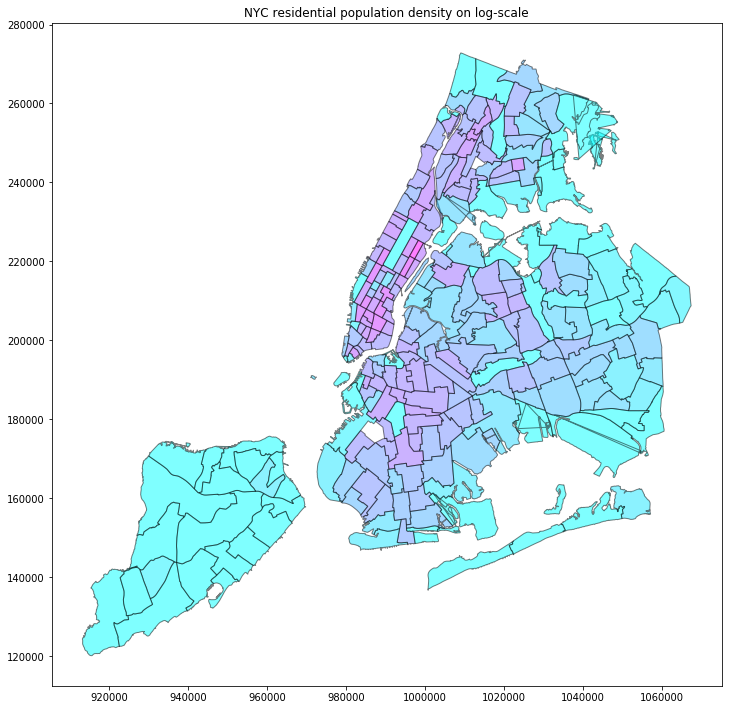

In [14]:
#plot residential population density on the log-scale
plot_on_map(tzs,Pdata,'totalR',areaNorm=True,logScale=True)

### Fig.1 NYC Residential Population Density Map on log-scale.
### Red/purple-ish color is for higher residential population density in the taxi zone. Uptown east, midtown, and downtown Manhattan have the highest residential population density. So do some taxi zones in Bronx, Queens, and Brooklyn that are closer geographically to Manhattan.  